In [1]:
# basics
import os
import utils
import numpy as np
from tqdm.notebook import tqdm 


# torch
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import lightning as L


# custom modules
from data_acquisition import DataHandler
from data_preparation import apply_preprocessing_pipeline


# Configure logging for the pipeline
logger = utils.setup_logger(level='INFO')

In [2]:
cities = ["Aachen", "CapeTown"]


datahandler = DataHandler(logger, path_to_data_directory="data")


import os
images = []
sparse_masks=[]
dense_masks=[]
boundary_masks=[]

for city in tqdm(cities):
    buildings = None
    if not os.path.exists(os.path.join(datahandler.path_to_data_directory,city,'building_mask_dense.tif')):
        print("loading local buildings")
        buildings = datahandler.get_buildings(city)
    images.append(datahandler.get_satellite_image(city).transpose(2, 0, 1))
    sparse_masks.append(datahandler.get_building_mask(city, all_touched=False, loaded_buildings=buildings))
    dense_masks.append(datahandler.get_building_mask(city, all_touched=True, loaded_buildings=buildings))
    boundary_masks.append(datahandler.get_boundaries_mask(city))




2024-07-07 16:15:27,491 - root - INFO - __init__ - Data directory already exists


  0%|          | 0/2 [00:00<?, ?it/s]

2024-07-07 16:15:27,505 - root - INFO - get_satellite_image - Aachen: Using local satellite image
2024-07-07 16:15:27,508 - rasterio._env - WARNING - open - CPLE_AppDefined in data/Aachen/openEO.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining no

In [3]:
boundary_masks[1].shape, dense_masks[1].shape, images[1].shape, sparse_masks[1].shape

((3868, 4184), (3868, 4184), (6, 3868, 4184), (3868, 4184))

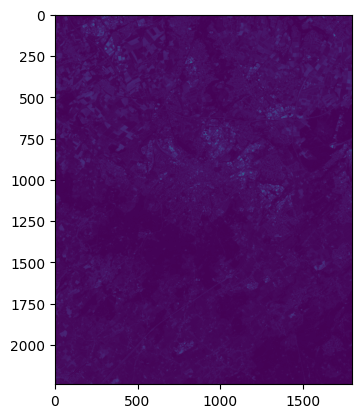

In [4]:
import  matplotlib.pyplot as plt
images[0].shape
plt.imshow(images[0][0,:,:])
plt.show()


In [9]:
from utilities.dataset_jlb import CityDataset
dataset = CityDataset(
    "/home/jlb/Projects/architecture-of-ml-systems/data",
    cities=cities,
    images=images,
    dense_mask=dense_masks,
    boundaries_mask=boundary_masks,
)

Creating Patches from Images: 0it [00:00, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

In [10]:
train_data, val_data = dataset.train_val_split(0.1)

Train:
Number of samples: 3168
Shape of Train data (data, label) (6, 32, 32) (32, 32)
Val:
Number of samples: 352
Shape of Val data (data, label) (6, 32, 32) (32, 32)
**************************************************
Mean percentage of 1 labels in train: 0.341598356613005
Mean percentage of 1 labels in val: 0.34623579545454547
Mean percentage of 1 labels in all data: 0.34206210049715907
**************************************************
Std of percentage 1 labels in train: 0.19576193152678048
Std of percentage 1 labels in val: 0.19739957992902343
Std of percentage 1 labels in all data: 0.19593125169995879
**************************************************
Min percentage of 1 labels in train: 0.1005859375
Min percentage of 1 labels in val: 0.1005859375
Min percentage of 1 labels in all data: 0.1005859375
**************************************************
Max percentage of 1 labels in train: 0.974609375
Max percentage of 1 labels in val: 0.9150390625
Max percentage of 1 labels in all da

In [8]:
dataset.get_cities()

In [ ]:
dataset[0]["data"].shape

(6, 32, 32)

In [ ]:
dataset.set_channels([0,1,4])
dataset[0]["data"].shape

(3, 32, 32)